In [1]:
from conditional_feinsum import init_spn
import torch
from torch.autograd import Variable
from torch.utils.data import Subset, DataLoader
from torchvision.datasets import ImageNet
from torchvision.transforms import Compose, CenterCrop, Resize, ToTensor
from utils import set_einet_weights, extract_image_patches, get_surrounding_patches
import numpy as np
from nns import MLP
import config
import torch.nn.functional as F
from PIL import Image

In [3]:
device = torch.device('cuda:0')
einet = init_spn(device)

{0}


In [4]:
num_params = 0
for n, p in einet.named_parameters():
    print(n)
    print(p.shape)
    num_params += np.prod(list(p.shape))
num_params

einet_layers.0.ef_array.params
torch.Size([3136, 10, 1, 6])
einet_layers.1.params
torch.Size([10, 10, 10, 4])
einet_layers.2.params
torch.Size([10, 10, 1, 2])
einet_layers.3.params
torch.Size([1, 1, 2])


192362

In [4]:
transform = Compose([ToTensor(), Resize(112), CenterCrop(112)])
imagenet = ImageNet('/storage-01/datasets/imagenet/', transform=transform)
clusters = np.load('/storage-01/ml-jseng/imagenet-clusters/vit_cluster_minibatch_10K.npy')
img_ids = np.argwhere(clusters == 2400).flatten()
subset = Subset(imagenet, img_ids)
loader = DataLoader(subset, 32)

In [5]:
def train(einet, train_loader, num_epochs, i, j, device):

    """
        Train ConFeinsum
    """
    out_dims = []
    for i, p in enumerate(einet.parameters()):
        if i == 0:
            nv, k, a, th = p.shape
            # split mean and variance parameters as variance
            # gets relu applied (cannot be negative)
            out_dims.append([nv, k, a, th // 2])
            out_dims.append([nv, k, a, th // 2])
        else:
            out_dims.append(list(p.shape))

    in_dim = (3*config.num_dims*config.num_vars) + 1000
    mlp = MLP(in_dim, out_dims, [256, 512]).to(device)

    optim = torch.optim.Adam(mlp.parameters(), 0.01)

    for epoch in range(num_epochs):
        total_ll = 0.0
        for x, y in train_loader:
            optim.zero_grad()
            x = x.to(device)
            y = y.to(device)
            # patch images and obtain 8x8 patches
            patches = extract_image_patches(x, config.height, config.width)
            x_in = patches[:, :, i, j]
            x_prev = get_surrounding_patches(patches, i, j, device)
            # flatten all previous patches and concat along feature dimension for NN
            x_prev = [x.squeeze().reshape(x_in.shape[0], -1) for x in x_prev]
            x_prev = torch.cat(x_prev, dim=1)
            y_oh = F.one_hot(y, num_classes=1000)
            x_prev = torch.cat([x_prev, y_oh], dim=1)
            einet_params = mlp(x_prev)
            
            ll = 0.
            x_in = x_in.permute((0, 2, 3, 1))
            x_in = x_in.reshape(x_in.shape[0], config.num_vars, config.num_dims)


            # set einet parameters for each batch as parameters differ
            # for each sample
            for k in range(x.shape[0]):
                einet_param = [ep[k] for ep in einet_params]
                einet = set_einet_weights(einet, einet_param)

                # evaluate log-likelihood
                x_in_img = x_in[k].unsqueeze(0)

                ll += einet(x_in_img).sum()

            ll.backward()
            total_ll += ll
            #print(einet.einet_layers[0].ef_array.ll.grad.shape)
            #print([(n, p.grad) for n, p in einet.named_parameters()])
            #print([e.grad for e in einet_params])
            print([(n, p.grad) for n, p in mlp.named_parameters()])
            optim.step()
        print(f"Epoch {epoch} \t LL: {total_ll}")

    return einet, mlp

In [6]:
device = torch.device('cuda:0')
einet = init_spn(device)
einet, mlp = train(einet, loader, 5, 2, 2, device)

{0}


/home/ml-jseng/anaconda3/envs/federated-spn/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[('linear_layers.0.weight', None), ('linear_layers.0.bias', None), ('linear_layers.1.weight', None), ('linear_layers.1.bias', None), ('heads.0.weight', None), ('heads.0.bias', None), ('heads.1.weight', None), ('heads.1.bias', None), ('heads.2.weight', None), ('heads.2.bias', None), ('heads.3.weight', None), ('heads.3.bias', None), ('heads.4.weight', None), ('heads.4.bias', None)]
[('linear_layers.0.weight', None), ('linear_layers.0.bias', None), ('linear_layers.1.weight', None), ('linear_layers.1.bias', None), ('heads.0.weight', None), ('heads.0.bias', None), ('heads.1.weight', None), ('heads.1.bias', None), ('heads.2.weight', None), ('heads.2.bias', None), ('heads.3.weight', None), ('heads.3.bias', None), ('heads.4.weight', None), ('heads.4.bias', None)]
[('linear_layers.0.weight', None), ('linear_layers.0.bias', None), ('linear_layers.1.weight', None), ('linear_layers.1.bias', None), ('heads.0.weight', None), ('heads.0.bias', None), ('heads.1.weight', None), ('heads.1.bias', None), (

KeyboardInterrupt: 

In [ ]:
for i in range(10):
    x, y = subset[i]
    x = x.unsqueeze(0)
    patches = extract_image_patches(x, 8, 8)
    x = patches[0, :, 2, 2]
    s = get_surrounding_patches(patches, 2, 2)[0][0]
    x = x * 255
    x = x.permute(1, 2, 0)
    s = s * 255
    s = s.permute(1, 2, 0)
    img = x.numpy().astype(np.uint8)
    pimg = Image.fromarray(img)
    pimg.show()
    imgs = s.numpy().astype(np.uint8)
    pimgs = Image.fromarray(imgs)
    pimgs.show()

In [12]:
a = torch.randn(3, 12, 3)
b = torch.cat((a, a**2), dim=-1)

In [14]:
b[0, 0]

tensor([-0.5499,  0.3395, -0.2652,  0.3024,  0.1153,  0.0703])

In [19]:
a = [1, 2, 3]
a[2:]

[3]

In [6]:
from torch.autograd import Variable
import torch.nn

In [14]:
w = Variable(torch.randn(3, 3), requires_grad=True)
x = torch.randn(5, 3)
y = torch.mm(x, w)
x_ = torch.randn(3, 5)
y_ = torch.mm(x_, y)
l = torch.sum(y_)
l.backward()

In [15]:
w.grad

tensor([[-0.1417, -0.1417, -0.1417],
        [ 0.6123,  0.6123,  0.6123],
        [ 0.3511,  0.3511,  0.3511]])

In [13]:
from conditional_feinsum import init_spn
from ceinsum import EinsumNetwork, Graph, EinetMixture
import torch
from torch.autograd import Variable
from torch.utils.data import Subset, DataLoader
from torchvision.datasets import ImageNet
from torchvision.transforms import Compose, CenterCrop, Resize, ToTensor
import numpy as np
from nns import MLP, CNN
import config
import torch.nn.functional as F
from PIL import Image

def init_spn(device):
    """
        Build a SPN (implemented as an einsum network). The structure is either
        the same as proposed in https://arxiv.org/pdf/1202.3732.pdf (referred to as
        poon-domingos) or a binary tree.

        In case of poon-domingos the image is split into smaller hypercubes (i.e. a set of
        neighbored pixels) where each pixel is a random variable. These hypercubes are split further
        until we operate on pixel-level. The spplitting is done randomly. For more information
        refer to the link above.
    """

    if config.structure == 'poon-domingos':
        pd_delta = [[config.height / d, config.width / d] for d in config.pd_num_pieces]
        graph = Graph.poon_domingos_structure(shape=(config.height, config.width), delta=pd_delta)
    elif config.structure == 'binary-trees':
        graph = Graph.random_binary_trees(num_var=config.num_vars, depth=config.depth, num_repetitions=config.num_repetitions)
    elif config.structure == 'flat-binary-tree':
        graph = Graph.binary_tree_spn(shape=(config.height, config.width))
    else:
        raise AssertionError("Unknown Structure")

    args = EinsumNetwork.Args(
            num_var=config.num_vars,
            num_dims=config.num_dims,
            num_classes=1,
            num_sums=config.K,
            num_input_distributions=config.K,
            exponential_family=config.exponential_family,
            exponential_family_args=config.exponential_family_args,
            online_em_frequency=config.online_em_frequency,
            online_em_stepsize=config.online_em_stepsize)
    
    in_dim = (3*config.num_dims*config.num_vars) #+ 1000
    out_dims = [[config.num_vars, config.K, 1, config.num_dims],
                [config.num_vars, config.K, 1, config.num_dims], 
                [config.K, config.K, config.K, 4],
                [config.K, config.K, 1, 2],
                [1, 1, 2]]
    #mlp = CNN(out_dims)
    mlp = MLP(in_dim, out_dims, [512, 256]).to(device)
   # for l in mlp.linear_layers:
   #     torch.nn.init.xavier_normal_(l.weight)
   # for h in mlp.heads:
   #     torch.nn.init.xavier_normal_(h.weight)
    einet = EinsumNetwork.EinsumNetwork(graph, mlp, (14, 14), args)
    einet.initialize()
    einet.to(device)
    return einet

In [2]:
transform = Compose([ToTensor(), Resize(112), CenterCrop(112)])
imagenet = ImageNet('/storage-01/datasets/imagenet/', transform=transform)
clusters = np.load('/storage-01/ml-jseng/imagenet-clusters/vit_cluster_minibatch_10K.npy')
img_ids = np.argwhere(clusters == 2400).flatten()
subset = Subset(imagenet, img_ids)
loader = DataLoader(subset, 64)
device = torch.device('cuda:0')

In [3]:
def train(einet, train_loader, num_epochs, i, j, device):

    """
        Train ConFeinsum
    """

    optim = torch.optim.Adam(einet.param_nn.parameters(), 0.004)
    lr_schedule = torch.optim.lr_scheduler.ExponentialLR(optim, 0.97)
    #halving_rate = 15
    #epochs_since_last_halving = 0

    for epoch in range(num_epochs):
        total_ll = 0.0
        print(f"LR={round(lr_schedule.get_lr()[0], 7)}")
        for x, y in train_loader:
            optim.zero_grad()
            x = x.to(device)
            y = y.to(device)
            
            ll = einet(x, y, i, j)
            ll.backward()

            #torch.nn.utils.clip_grad.clip_grad_norm_(einet.param_nn.parameters(), 1.)

            total_ll += ll

            optim.step()
        #epochs_since_last_halving += 1
        lr_schedule.step()

        #if epochs_since_last_halving % halving_rate == 0 and halving_rate > 5:
        #    print("Halving lr")
        #    for g in optim.param_groups:
        #        g['lr'] = g['lr'] * 0.5
            #halving_rate = int(halving_rate * 0.5)
        #   epochs_since_last_halving = 0
        print(f"Epoch {epoch} \t LL: {total_ll}")

    return einet

In [4]:
device = torch.device('cuda:0')
einet = init_spn(device)
einet = train(einet, loader, 150, 1, 1, device)

{0}
LR=0.004


/home/ml-jseng/anaconda3/envs/federated-spn/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:595: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/home/ml-jseng/anaconda3/envs/federated-spn/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antial

Epoch 0 	 LL: 267959.625
LR=0.0037636
Epoch 1 	 LL: 151659.3125
LR=0.0036507
Epoch 2 	 LL: 41982.29296875
LR=0.0035412
Epoch 3 	 LL: 29960.900390625
LR=0.0034349
Epoch 4 	 LL: 28621.775390625
LR=0.0033319
Epoch 5 	 LL: 27341.064453125
LR=0.0032319
Epoch 6 	 LL: 25901.0546875
LR=0.003135
Epoch 7 	 LL: 24085.529296875
LR=0.0030409
Epoch 8 	 LL: 23046.271484375
LR=0.0029497
Epoch 9 	 LL: 22000.71484375
LR=0.0028612
Epoch 10 	 LL: 21570.361328125
LR=0.0027754
Epoch 11 	 LL: 21217.775390625
LR=0.0026921
Epoch 12 	 LL: 20796.18359375
LR=0.0026113
Epoch 13 	 LL: 20456.345703125
LR=0.002533
Epoch 14 	 LL: 20291.25
LR=0.002457
Epoch 15 	 LL: 20155.861328125
LR=0.0023833
Epoch 16 	 LL: 20029.078125
LR=0.0023118
Epoch 17 	 LL: 19935.4453125
LR=0.0022425
Epoch 18 	 LL: 19878.44140625
LR=0.0021752
Epoch 19 	 LL: 19824.32421875
LR=0.0021099
Epoch 20 	 LL: 19785.111328125
LR=0.0020466
Epoch 21 	 LL: 19759.232421875
LR=0.0019852
Epoch 22 	 LL: 19746.51953125
LR=0.0019257
Epoch 23 	 LL: 19726.4375
LR=0

In [14]:
torch.save(einet.param_nn, './models/model_1_1')

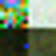

In [12]:
x_, y_ = next(iter(loader))
x_, y_ = x_.to(device), y_.to(device)
x_in, y_in = x_[0].unsqueeze(0), y_[0]
s = einet.sample(x_in, y_in, 1, 1)
s = s.squeeze().cpu()
s = s.reshape(config.height, config.width, 3)
s = s * 255
img = s.numpy().astype(np.uint8)
pimg = Image.fromarray(img)
pimg = pimg.resize((56, 56))
pimg.show()

In [9]:
import torch
def softmax_temp(x, t=1.0, dim=1):
    ex = torch.exp(x / t)
    s = torch.sum(ex, dim=dim).unsqueeze(1)
    return ex / s

a = torch.randn(10, 5)
s1 = softmax_temp(a, t=1.5)
s2 = torch.nn.functional.softmax(a)
print(s1)
print(s2)

tensor([[0.3238, 0.1136, 0.2181, 0.1661, 0.1784],
        [0.1459, 0.4096, 0.0945, 0.2202, 0.1298],
        [0.0708, 0.1857, 0.0859, 0.0978, 0.5598],
        [0.1229, 0.3782, 0.2502, 0.1008, 0.1478],
        [0.2710, 0.1794, 0.2806, 0.2012, 0.0678],
        [0.1280, 0.1713, 0.4359, 0.1471, 0.1177],
        [0.2160, 0.2227, 0.1990, 0.2155, 0.1468],
        [0.1253, 0.3722, 0.1130, 0.3026, 0.0868],
        [0.1742, 0.2959, 0.0140, 0.3497, 0.1662],
        [0.1915, 0.0413, 0.3288, 0.1525, 0.2860]])
tensor([[0.3942, 0.0819, 0.2179, 0.1448, 0.1612],
        [0.1121, 0.5274, 0.0584, 0.2079, 0.0941],
        [0.0328, 0.1395, 0.0439, 0.0533, 0.7304],
        [0.0880, 0.4750, 0.2556, 0.0654, 0.1160],
        [0.2979, 0.1604, 0.3138, 0.1906, 0.0373],
        [0.0914, 0.1414, 0.5741, 0.1126, 0.0805],
        [0.2228, 0.2333, 0.1970, 0.2220, 0.1248],
        [0.0885, 0.4528, 0.0758, 0.3319, 0.0510],
        [0.1426, 0.3157, 0.0032, 0.4056, 0.1329],
        [0.1700, 0.0170, 0.3822, 0.1207, 0.3101]]

/tmp/ipykernel_1862780/4153709868.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  s2 = torch.nn.functional.softmax(a)


In [254]:
def embed_patch_in_img(img, patch, i, j):
    """
        img shape = [1, 3, h, w]
        patch shape = [1, 3, 8, 8]
        (i, j) = patch index
    """
    i_start, i_end = i*patch.shape[-1], (i+1)*patch.shape[-1]
    j_start, j_end = j*patch.shape[-1], (j+1)*patch.shape[-1]
    img[0, :, i_start:i_end, j_start:j_end] = patch
    return img

In [291]:
# sample from trained SPN
device = torch.device('cuda:0')
sqrt_num_patches = 5
patch_ids = [[i, j] for i in range(1, sqrt_num_patches-1) for j in range(1, sqrt_num_patches-1)]
einet = init_spn(device)
sample_arr = []
x_, y_ = next(iter(loader))
x_, y_ = x_.to(device), y_.to(device)
x_in, y_in = x_[0].unsqueeze(0), y_[0]
last_s = None
img = torch.zeros(1, 3, 112, 112).to(device)
for i, j in patch_ids:
    param_nn = torch.load(f'./models/model_{i}_{j}')
    param_nn = param_nn.to(device)
    einet.param_nn = param_nn
    if True:
        s = einet.sample(x_in, y_in, i, j)
        s = s.reshape(1, 8, 8, 3).permute(0, 3, 1, 2)
        img = embed_patch_in_img(img, s, i, j)
    else:
        s = einet.sample(img, y_in, i, j)
        s = s.reshape(1, 8, 8, 3).permute(0, 3, 1, 2)
        img = embed_patch_in_img(img, s, i, j)

{0}


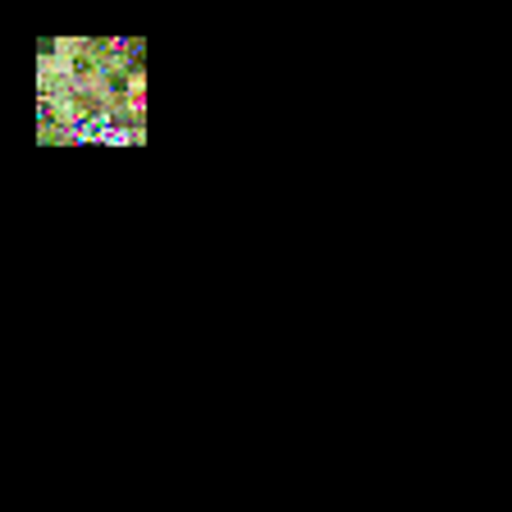

In [292]:
simg = img[0].permute(1, 2, 0).cpu().numpy()
simg = simg * 255
pil_simg = Image.fromarray(simg.astype(np.uint8))
pil_simg = pil_simg.resize((512, 512))
pil_simg.show()

In [7]:
from einsum import EinsumNetwork, EinetMixture
import os
from utils import save_image_stack

In [13]:
def sample(n):
    clusters = np.load('/storage-01/ml-jseng/imagenet-clusters/vit_cluster_minibatch.npy')
    unique_clusters = np.unique(clusters)
    weights = []
    for c in unique_clusters:
        cidx = np.argwhere(clusters == c).flatten()
        weights.append(len(cidx) / len(clusters))
    weights = np.array(weights)
    rand_clusters = np.random.choice(np.arange(len(weights)), p=weights, size=n)
    samples = torch.zeros(n, 3, 112, 112)
    for i, rc in enumerate(rand_clusters):
        model_file = f'./checkpoints/chk_{rc}.pt'
        einet: EinsumNetwork.EinsumNetwork = torch.load(model_file)
        s = einet.sample(1).cpu()
        s = s.reshape(-1, 3, 112, 112)
        samples[i, ...] = s
    samples = samples.permute(0, 2, 3, 1).numpy()
    img_path = './samples_mixture.png'
    save_image_stack(samples, 5, 5, img_path, margin_gray_val=0., frame=2, frame_gray_val=0.0)

In [14]:
sample(25)

: 